In [4]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
import pdb
from matplotlib import colors

sys.path.append('..')
from utils import gen_covariance
from misc import calc_avg_cov, calc_clustering, group_dictionaries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load from pickle
with open('../../selectionfinal/pp_results.dat', 'rb') as f:
    uoi = pickle.load(f)
    scad = pickle.load(f)
    mcp = pickle.load(f)
    en = pickle.load(f)
    lasso = pickle.load(f)

In [17]:
uoil = uoi

In [36]:
def filter_by_dict(df, root_key, dict_filter):
    
    col = df[root_key].values
    
    filtered_idxs = []
    
    for i, c in enumerate(col):
        match = True
        for key, val in dict_filter.items(): 
            if c[key] != val:
                match = False
        if match:
            filtered_idxs.append(i)
    
    return df.iloc[filtered_idxs]

In [37]:
# Shortcut to apply multiple filters to pandas dataframe
def apply_df_filters(df, **kwargs):
    
    filtered_df = df
    
    for key, value in kwargs.items():
    
        # If the value is the dict 
        if type(value) == dict:
            
            filtered_df = filter_by_dict(filtered_df, key, value)
            
        else:
    
            filtered_df = filtered_df.loc[filtered_df[key] == value]

    return filtered_df

In [6]:
# Task: Get the unique dictionaries of cov_params from the dataframe 
def unique_cov_params(df):
    cov_params = df['cov_params'].values
    unique_cov_params, cov_idxs = group_dictionaries(cov_params, None)
    unique_cov_dicts = []
    for ucp in unique_cov_params:
        ucd = {'correlation' : ucp[0], 'block_size' : ucp[1], 'L' : ucp[2], 't': ucp[3]}
        unique_cov_dicts.append(ucd)
    
    return unique_cov_dicts, cov_idxs

In [2]:
# Task: Given the indices of repeated elements, select the FNR and FPR and average them together
def average_fields(df, fields, rep_idxs):
    results = []
        
    for i, field in enumerate(fields):
        # Pass in None to not average
        if rep_idxs is None:
            values = np.zeros(df.shape[0])
            for j in range(df.shape[0]):
                values[j] = df.iloc[j][field]
        else:
            values = np.zeros(len(rep_idxs))
            for j, rep_idx in enumerate(rep_idxs):
                values[j] = np.mean(df.iloc[rep_idx][field])

        results.append(values)
    
    return tuple(results)

In [7]:
from collections import Counter

In [8]:
# Task: start from the smallest list/array, and then truncate the rest of 
def array_intersection(jagged_array): 

    # Take "intersections" between successive elements of the jagged array. keep track 
    # of the smallest common array. 
    ref = jagged_array[0]
        
    for i in range(1, jagged_array.size):
        intersection = np.array([elem for elem in jagged_array[i] if elem in ref])
        if intersection.size < ref.size:
            ref = intersection            

    ref = ref[np.newaxis, :]
    # Tile the ref 
    rect_array = np.tile(ref, (jagged_array.size, 1))

    # Keep track of the indices in each jagged element that survive through the intersection 
    # process
    ref_idxs = []
    
    for i in range(jagged_array.size):
        ref_idxs.append(np.array([idx for idx in np.arange(jagged_array[i].size) if jagged_array[i][idx] in ref]))
    
    return rect_array, ref_idxs

In [44]:
def weighted_rates(df, n_features, sparsity_max = 1):
    
    sparsity = np.unique(df['sparsity'])
    sparsity = sparsity[sparsity < sparsity_max]
    
    weighted_rates = []
    avg_cov = []
    for i, s, in enumerate(sparsity):
        df_ = apply_df_filters(df, sparsity = s)
        
        # Calculate average covariance
        cov_params, rep_idxs = unique_cov_params(df_)
        avg_cov.append(np.array([calc_avg_cov(n_features, **cp) for cp in cov_params]))
        FNR_, FPR_ = average_fields(df_, ['FNR', 'FPR'], rep_idxs)        
        # Want to calculate a single statistic that appropriately weights the FNR/FPR
        weights = np.array([FNR_FPR_weight(s, FNR_[j], FPR_[j]) for j in range(len(FNR_))])
        weighted_rates.append(weights)
    
    # Hopefully these arrays aren't jagged
    weighted_rates = np.array(weighted_rates)
    avg_cov = np.array(avg_cov)
    
    # Sum the weighted rates across sparsity, divide by number of sparsities 
    try:
        weighted_rates = np.mean(weighted_rates, axis = 0)
        avg_cov = avg_cov[0, :]
    except:
        # lists are uneven in size --> need to take the intersection (with duplicates) of all elements
        avg_cov, trimmed_idxs = array_intersection(avg_cov)
        avg_cov = avg_cov[0, :]
        weighted_rates = np.array([weighted_rates[j][trimmed_idxs[j]] for j in range(weighted_rates.size)])
        weighted_rates = np.mean(weighted_rates, axis = 0)
    
    # Sort by avg_cov
    cov_order = np.argsort(avg_cov)
    weighted_rates = weighted_rates[cov_order]
    avg_cov = avg_cov[cov_order]    
                
    return moving_average(weighted_rates), moving_average(avg_cov)         

In [9]:
import scipy.integrate as integrate

In [10]:
def FNR_FPR_weight(sparsity, FNR, FPR):
    
    # Given the coordinates in the (FNR, FPR) plane, calculate the line integral from the origin to the point in question

    weight_fn = lambda u, x, y, s : ((1 - s) * y * u + s * x * u)/(s * (2 - x * u - y * u) + y * u)
    weight, _  = integrate.quad(weight_fn, 0, 1, args = (FNR, FPR, sparsity))
    return weight    

In [11]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [38]:
en_ = apply_df_filters(en, betadict = {'betawidth' : np.inf})

In [47]:
en_.iloc[0]

FNR                                                                 0.25
FPR                                                               0.0125
betadict               {'betawidth': inf, 'beta': [[2.004988874826836...
cov_params             {'correlation': 0, 'block_size': 25, 'L': 1, '...
cov_type                                                   interpolation
est_score                                                            BIC
gamma                                                                [3]
index                                                                 14
kappa                                                                  2
l1_ratios                                    [0.1, 0.5, 0.75, 0.9, 0.95]
n_alphas                                                             100
n_boots_est                                                           25
n_boots_sel                                                           25
n_features                                         

In [49]:
# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

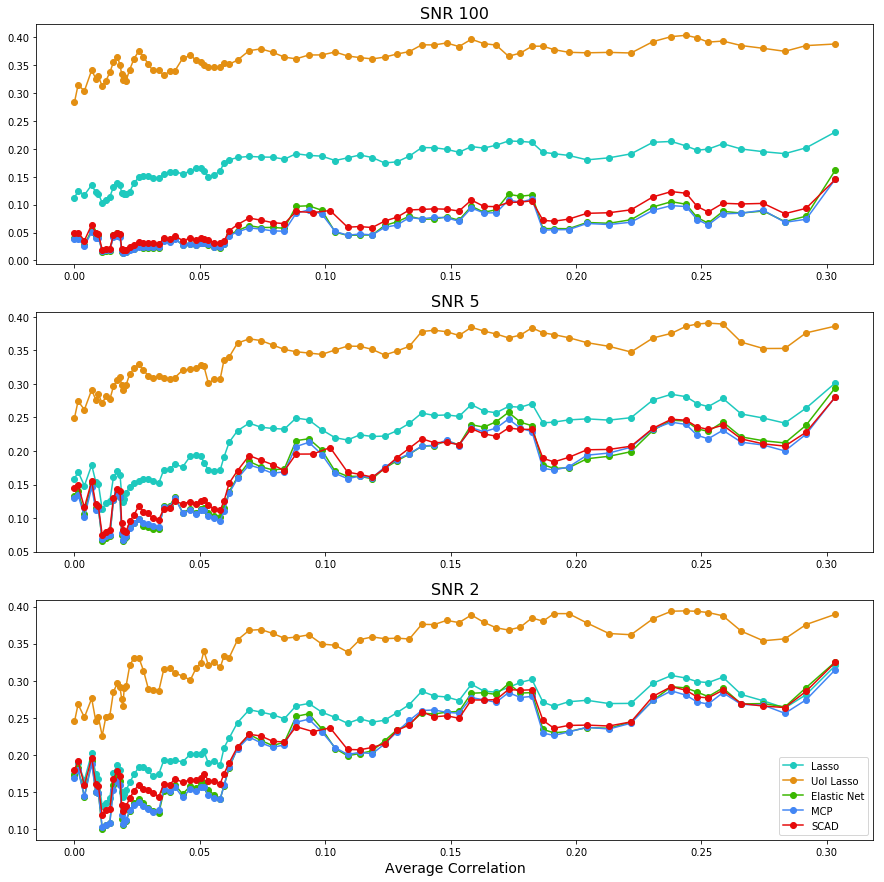

In [51]:
fig, ax = plt.subplots(3, 1, figsize = (15, 15))

################# SNR 100 ################################################################

en_ = apply_df_filters(en, kappa=100, selection_method='BIC')
lasso_ = apply_df_filters(lasso, kappa=100, selection_method='BIC', betadict = {'betawidth' : np.inf})
uoil_ = apply_df_filters(uoil,  kappa=100, selection_method='BIC', betadict = {'betawidth' : np.inf})
mcp_ = apply_df_filters(mcp, kappa=100, selection_method='BIC', betadict = {'betawidth' : np.inf})
scad_ = apply_df_filters(scad, kappa=100, selection_method='BIC', betadict = {'betawidth' : np.inf})

# Extract weights
enw, enc = weighted_rates(en_, 500)
lassow, lassoc = weighted_rates(lasso_, 500)
uoilw, uoilc = weighted_rates(uoil_, 500)
mcpw, mcpc = weighted_rates(mcp_, 500)
scadw, scadc = weighted_rates(scad_, 500)

ax[0].plot(lassoc, lassow, '-o', c = c4[0])
ax[0].plot(enc, enw, '-o', c = c5[0])
ax[0].plot(scadc, scadw, '-o', c = c1[0])
ax[0].plot(mcpc, mcpw, '-o', c = c2[0])
ax[0].plot(uoilc, uoilw, '-o', c = c3[0])
ax[0].set_title('SNR 100', fontsize = 16)

# SNR 5 #
en_ = apply_df_filters(en, kappa=5, selection_method='BIC', betadict = {'betawidth' : np.inf})
lasso_ = apply_df_filters(lasso, kappa=5, selection_method='BIC', betadict = {'betawidth' : np.inf})
uoil_ = apply_df_filters(uoil,  kappa=5, selection_method='BIC', betadict = {'betawidth' : np.inf})
mcp_ = apply_df_filters(mcp, kappa=5, selection_method='BIC', betadict = {'betawidth' : np.inf})
scad_ = apply_df_filters(scad, kappa=5, selection_method='BIC', betadict = {'betawidth' : np.inf})

# Extract weights
enw, enc = weighted_rates(en_, 500)
lassow, lassoc = weighted_rates(lasso_, 500)
uoilw, uoilc = weighted_rates(uoil_, 500)
mcpw, mcpc = weighted_rates(mcp_, 500)
scadw, scadc = weighted_rates(scad_, 500)

ax[1].plot(lassoc, lassow, '-o', c = c4[0])
ax[1].plot(enc, enw, '-o', c = c5[0])
ax[1].plot(scadc, scadw, '-o', c = c1[0])
ax[1].plot(mcpc, mcpw, '-o', c = c2[0])
ax[1].plot(uoilc, uoilw, '-o', c = c3[0])
ax[1].set_title('SNR 5', fontsize = 16)

# SNR 2
# Filter to a single betawidth, kappa
en_ = apply_df_filters(en, kappa=2, selection_method='BIC', betadict = {'betawidth' : np.inf})
lasso_ = apply_df_filters(lasso, kappa=2, selection_method='BIC', betadict = {'betawidth' : np.inf})
uoil_ = apply_df_filters(uoil,  kappa=2, selection_method='BIC', betadict = {'betawidth' : np.inf})
mcp_ = apply_df_filters(mcp, kappa=2, selection_method='BIC', betadict = {'betawidth' : np.inf})
scad_ = apply_df_filters(scad, kappa=2, selection_method='BIC', betadict = {'betawidth' : np.inf})

# Extract weights
enw, enc = weighted_rates(en_, 500)
lassow, lassoc = weighted_rates(lasso_, 500)
uoilw, uoilc = weighted_rates(uoil_, 500)
mcpw, mcpc = weighted_rates(mcp_, 500)
scadw, scadc = weighted_rates(scad_, 500)

ax[2].plot(lassoc, lassow, '-o', c = c4[0])
ax[2].plot(enc, enw, '-o', c = c5[0])
ax[2].plot(scadc, scadw, '-o', c = c1[0])
ax[2].plot(mcpc, mcpw, '-o', c = c2[0])
ax[2].plot(uoilc, uoilw, '-o', c = c3[0])
ax[2].set_title('SNR 2', fontsize = 16)
ax[2].set_xlabel('Average Correlation', fontsize = 14)

ax[2].legend(['Lasso', 'Elastic Net', 'SCAD', 'MCP', r'$UoI_{Lasso}$'], loc = 'lower right')
plt.savefig('pathint_snr.pdf', bbox_inches = 'tight', pad_inches = 0)

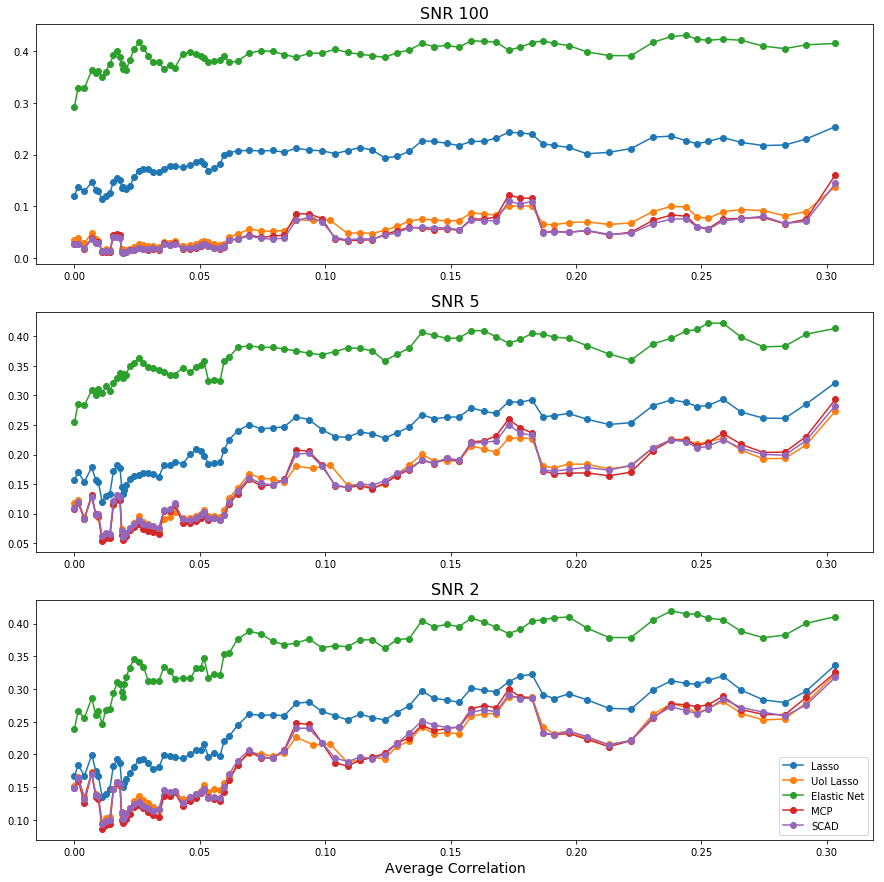

In [45]:
# Narrow the range of sparsity considered
fig, ax = plt.subplots(3, 1, figsize = (15, 15))

################# SNR 100 ################################################################

en_ = apply_df_filters(en, kappa=100, selection_method='BIC')
lasso_ = apply_df_filters(lasso, kappa=100, selection_method='BIC', betadict = {'betawidth' : np.inf})
uoil_ = apply_df_filters(uoil,  kappa=100, selection_method='BIC', betadict = {'betawidth' : np.inf})
mcp_ = apply_df_filters(mcp, kappa=100, selection_method='BIC', betadict = {'betawidth' : np.inf})
scad_ = apply_df_filters(scad, kappa=100, selection_method='BIC', betadict = {'betawidth' : np.inf})

# Extract weights
enw, enc = weighted_rates(en_, 500, sparsity_max = 0.5)
lassow, lassoc = weighted_rates(lasso_, 500, sparsity_max = 0.5)
uoilw, uoilc = weighted_rates(uoil_, 500, sparsity_max = 0.5)
mcpw, mcpc = weighted_rates(mcp_, 500, sparsity_max = 0.5)
scadw, scadc = weighted_rates(scad_, 500, sparsity_max = 0.5)

ax[0].plot(lassoc, lassow, '-o')
ax[0].plot(uoilc, uoilw, '-o')
ax[0].plot(enc, enw, '-o')
ax[0].plot(mcpc, mcpw, '-o')
ax[0].plot(scadc, scadw, '-o')
ax[0].set_title('SNR 100', fontsize = 16)

# SNR 5 #
en_ = apply_df_filters(en, kappa=5, selection_method='BIC', betadict = {'betawidth' : np.inf})
lasso_ = apply_df_filters(lasso, kappa=5, selection_method='BIC', betadict = {'betawidth' : np.inf})
uoil_ = apply_df_filters(uoil,  kappa=5, selection_method='BIC', betadict = {'betawidth' : np.inf})
mcp_ = apply_df_filters(mcp, kappa=5, selection_method='BIC', betadict = {'betawidth' : np.inf})
scad_ = apply_df_filters(scad, kappa=5, selection_method='BIC', betadict = {'betawidth' : np.inf})

# Extract weights
enw, enc = weighted_rates(en_, 500, sparsity_max = 0.5)
lassow, lassoc = weighted_rates(lasso_, 500, sparsity_max = 0.5)
uoilw, uoilc = weighted_rates(uoil_, 500, sparsity_max = 0.5)
mcpw, mcpc = weighted_rates(mcp_, 500, sparsity_max = 0.5)
scadw, scadc = weighted_rates(scad_, 500, sparsity_max = 0.5)

ax[1].plot(lassoc, lassow, '-o')
ax[1].plot(uoilc, uoilw, '-o')
ax[1].plot(enc, enw, '-o')
ax[1].plot(mcpc, mcpw, '-o')
ax[1].plot(scadc, scadw, '-o')
ax[1].set_title('SNR 5', fontsize = 16)

# SNR 2
# Filter to a single betawidth, kappa
en_ = apply_df_filters(en, kappa=2, selection_method='BIC', betadict = {'betawidth' : np.inf})
lasso_ = apply_df_filters(lasso, kappa=2, selection_method='BIC', betadict = {'betawidth' : np.inf})
uoil_ = apply_df_filters(uoil,  kappa=2, selection_method='BIC', betadict = {'betawidth' : np.inf})
mcp_ = apply_df_filters(mcp, kappa=2, selection_method='BIC', betadict = {'betawidth' : np.inf})
scad_ = apply_df_filters(scad, kappa=2, selection_method='BIC', betadict = {'betawidth' : np.inf})

# Extract weights
enw, enc = weighted_rates(en_, 500, sparsity_max = 0.5)
lassow, lassoc = weighted_rates(lasso_, 500, sparsity_max = 0.5)
uoilw, uoilc = weighted_rates(uoil_, 500, sparsity_max = 0.5)
mcpw, mcpc = weighted_rates(mcp_, 500, sparsity_max = 0.5)
scadw, scadc = weighted_rates(scad_, 500, sparsity_max = 0.5)

ax[2].plot(lassoc, lassow, '-o')
ax[2].plot(uoilc, uoilw, '-o')
ax[2].plot(enc, enw, '-o')
ax[2].plot(mcpc, mcpw, '-o')
ax[2].plot(scadc, scadw, '-o')
ax[2].set_title('SNR 2', fontsize = 16)
ax[2].set_xlabel('Average Correlation', fontsize = 14)

ax[2].legend(['Lasso', 'UoI Lasso', 'Elastic Net', 'MCP', 'SCAD'], loc = 'lower right')
#plt.savefig('pathint_selecmethod.pdf', bbox_inches = 'tight', pad_inches = 0)